In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
from os.path import join, isfile, isdir
from glob import glob
from PIL import Image
sns.set()

##Import any other packages you may need here

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.head()

## Load 'sample_labels.csv' data for pixel level assessments
##sample_df = pd.read_csv('sample_labels.csv')
##sample_df.sample(3)

Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           81              M            PA                 2500     2048   
4           81              F            PA                 2582     2991   

   OriginalImagePixelSpacing[x     y]  Unnamed: 11  
0                        0.143  0.143          NaN  
1                        0.143  0.143          NaN  
2                        0.168  0.168          NaN  
3                        0.171  0.171          NaN  
4                        0.143  0.143          NaN

In [3]:
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

Image Index                               Finding Labels  \
4463  00022234_000.png                                   No Finding   
2119  00010888_007.png                                       Nodule   
4584  00022877_024.png  Atelectasis|Infiltration|Pleural_Thickening   

      Follow-up #  Patient ID Patient Age Patient Gender View Position  \
4463            0       22234        039Y              M            PA   
2119            7       10888        061Y              F            PA   
4584           24       22877        056Y              F            AP   

      OriginalImageWidth  OriginalImageHeight  OriginalImagePixelSpacing_x  \
4463                2982                 2991                        0.143   
2119                2992                 2991                        0.143   
4584                3056                 2544                        0.139   

      OriginalImagePixelSpacing_y  
4463                        0.143  
2119                        0.143  
4584                        0.139

In [4]:
from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]

In [5]:
all_labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [6]:
# Create new columns for individual diseases kind of one hot encoding
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)


In [7]:
# Get percentage of diseases
all_xray_df[all_labels].sum()/len(all_xray_df)

Atelectasis           0.103095
Cardiomegaly          0.024759
Consolidation         0.041625
Edema                 0.020540
Effusion              0.118775
Emphysema             0.022440
Fibrosis              0.015037
Hernia                0.002025
Infiltration          0.177435
Mass                  0.051570
No Finding            0.538361
Nodule                0.056466
Pleural_Thickening    0.030191
Pneumonia             0.012763
Pneumothorax          0.047289
dtype: float64

[Text(0, 0.5, 'Number of Images with Label')]

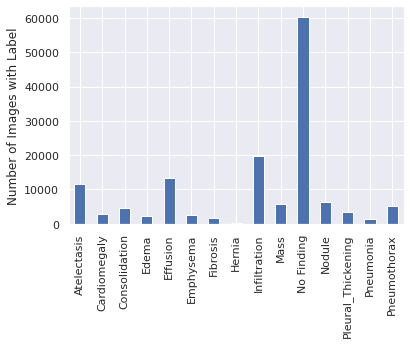

In [8]:
ax = all_xray_df[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

Inference : No Finding field almost ~53%, good that more than half of the population is healthy.
Infiltration,Effusion and Atelectalsis prevalence is more.
Pneumonis occurance is 1.2%.

In [9]:
all_xray_df

Image Index          Finding Labels  Follow-up #  Patient ID  \
0       00000001_000.png            Cardiomegaly            0           1   
1       00000001_001.png  Cardiomegaly|Emphysema            1           1   
2       00000001_002.png   Cardiomegaly|Effusion            2           1   
3       00000002_000.png              No Finding            0           2   
4       00000003_000.png                  Hernia            0           3   
...                  ...                     ...          ...         ...   
112115  00030801_001.png          Mass|Pneumonia            1       30801   
112116  00030802_000.png              No Finding            0       30802   
112117  00030803_000.png              No Finding            0       30803   
112118  00030804_000.png              No Finding            0       30804   
112119  00030805_000.png              No Finding            0       30805   

        Patient Age Patient Gender View Position  OriginalImage[Width  \
0                58              M            PA                 2682   
1                58              M            PA                 2894   
2                58              M            PA                 2500   
3                81              M            PA                 2500   
4                81              F            PA                 2582   
...             ...            ...           ...                  ...   
112115           39              M            PA                 2048   
112116           29              M            PA                 2048   
112117           42              F            PA                 2048   
112118           30              F            PA                 2048   
112119           27              M            PA                 2048   

        Height]  OriginalImagePixelSpacing[x  ...  Emphysema  Fibrosis  \
0          2749                        0.143  ...        0.0       0.0   
1          2729                        0.143  ...        1.0       0.0   
2          2048                        0.168  ...        0.0       0.0   
3          2048                        0.171  ...        0.0       0.0   
4          2991                        0.143  ...        0.0       0.0   
...         ...                          ...  ...        ...       ...   
112115     2500                        0.168  ...        0.0       0.0   
112116     2500                        0.168  ...        0.0       0.0   
112117     2500                        0.168  ...        0.0       0.0   
112118     2500                        0.168  ...        0.0       0.0   
112119     2500                        0.171  ...        0.0       0.0   

        Hernia  Infiltration  Mass  No Finding  Nodule  Pleural_Thickening  \
0          0.0           0.0   0.0         0.0     0.0                 0.0   
1          0.0           0.0   0.0         0.0     0.0                 0.0   
2          0.0           0.0   0.0         0.0     0.0                 0.0   
3          0.0           0.0   0.0         1.0     0.0                 0.0   
4          1.0           0.0   0.0         0.0     0.0                 0.0   
...        ...           ...   ...         ...     ...                 ...   
112115     0.0           0.0   1.0         0.0     0.0                 0.0   
112116     0.0           0.0   0.0         1.0     0.0                 0.0   
112117     0.0           0.0   0.0         1.0     0.0                 0.0   
112118     0.0           0.0   0.0         1.0     0.0                 0.0   
112119     0.0           0.0   0.0         1.0     0.0                 0.0   

        Pneumonia  Pneumothorax  
0             0.0           0.0  
1             0.0           0.0  
2             0.0           0.0  
3             0.0           0.0  
4             0.0           0.0  
...           ...           ...  
112115        1.0           0.0  
112116        0.0           0.0  
112117        0.0           0.0  
112118        0.0           0.0  
112119     

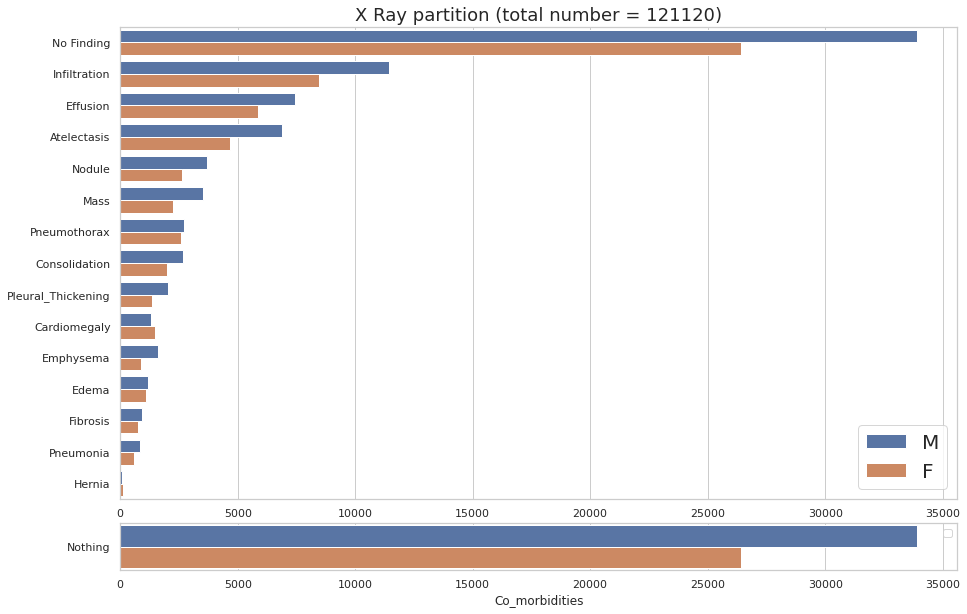

In [10]:
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
sns.set_style('whitegrid')
plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(8,1)
ax1 = plt.subplot(gs[:7, :])
ax2 = plt.subplot(gs[7, :])
data1 = pd.melt(all_xray_df,
             id_vars=['Patient Gender'],
             value_vars = all_labels,
             var_name = 'Category',
             value_name = 'Count')
data1 = data1.loc[data1.Count>0]
g=sns.countplot(y='Category',hue='Patient Gender',data=data1, ax=ax1, order = data1['Category'].value_counts().index)
ax1.set( ylabel="",xlabel="")
ax1.legend(fontsize=20)
ax1.set_title('X Ray partition (total number = 121120)',fontsize=18);

all_xray_df['Nothing']=all_xray_df['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

data2 = pd.melt(all_xray_df,
             id_vars=['Patient Gender'],
             value_vars = list(['Nothing']),
             var_name = 'Category',
             value_name = 'Count')
data2 = data2.loc[data2.Count>0]
g=sns.countplot(y='Category',hue='Patient Gender',data=data2,ax=ax2)
ax2.set( ylabel="",xlabel="Co_morbidities")
ax2.legend('')
plt.subplots_adjust(hspace=.5)

Most commonly occuring co-morbidiites for pnemonia are Infiltration, Edema, Atelectasis,Effusion, Consolidation


In [11]:
data1

Patient Gender      Category  Count
34                   M   Atelectasis    1.0
68                   M   Atelectasis    1.0
73                   M   Atelectasis    1.0
92                   M   Atelectasis    1.0
111                  M   Atelectasis    1.0
...                ...           ...    ...
1681720              F  Pneumothorax    1.0
1681771              F  Pneumothorax    1.0
1681772              F  Pneumothorax    1.0
1681773              F  Pneumothorax    1.0
1681774              F  Pneumothorax    1.0

[141537 rows x 3 columns]

(array([4.2500e+02, 9.7800e+02, 1.5330e+03, 2.3050e+03, 3.7610e+03,
        5.1570e+03, 5.4630e+03, 8.3900e+03, 6.1900e+03, 7.2630e+03,
        9.1310e+03, 9.4600e+03, 1.0774e+04, 1.1726e+04, 9.3080e+03,
        9.9210e+03, 4.5270e+03, 3.0580e+03, 1.6150e+03, 7.4500e+02,
        2.5600e+02, 9.4000e+01, 2.4000e+01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        3.0000e+00, 4.0000e+00, 3.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

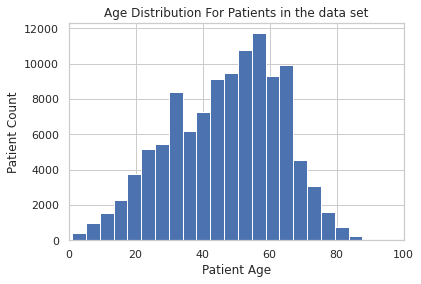

In [12]:

## EDA
# Patient demographic data
# Age exploration for all diseases

plt.xlim(0,100)
plt.xlabel('Patient Age')
plt.ylabel('Patient Count')
plt.title('Age Distribution For Patients in the data set')

plt.hist(all_xray_df['Patient Age'],bins=100)

The data set has patients whose age distribution looks like normal distribution. This means patients in the age group 20-70 have higher occurances of diseases including pnemonia.

(array([ 15.,  26.,  32.,  43.,  56.,  93.,  71., 114.,  80.,  85., 125.,
        110., 121., 127., 110., 105.,  59.,  26.,  19.,   9.,   3.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([  2. ,   6.1,  10.2,  14.3,  18.4,  22.5,  26.6,  30.7,  34.8,
         38.9,  43. ,  47.1,  51.2,  55.3,  59.4,  63.5,  67.6,  71.7,
         75.8,  79.9,  84. ,  88.1,  92.2,  96.3, 100.4, 104.5, 108.6,
        112.7, 116.8, 120.9, 125. , 129.1, 133.2, 137.3, 141.4, 145.5,
        149.6, 153.7, 157.8, 161.9

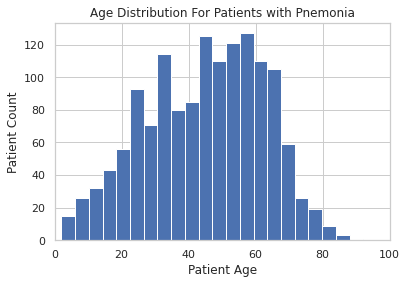

In [13]:
# age distribution for pneumonia
plt.xlim(0,100)

plt.xlabel('Patient Age')
plt.ylabel('Patient Count')
plt.title('Age Distribution For Patients with Pnemonia')
plt.hist(all_xray_df[all_xray_df.Pneumonia==1]['Patient Age'],bins=100)


For population with pnemonia, the age distribution resembles normal distribution. This means the population with age range 20-70, have more occurances of pnemonia from the data in the the given data set.

(array([63340.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 48780.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

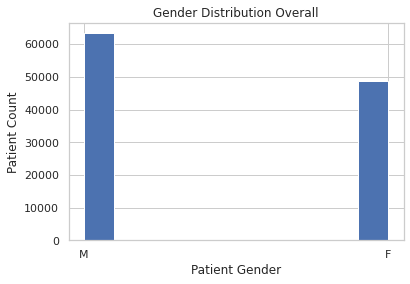

In [14]:
#Explore Gender
plt.xlabel('Patient Gender')
plt.ylabel('Patient Count')
plt.title('Gender Distribution Overall')

plt.hist(all_xray_df['Patient Gender'])

(array([838.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 593.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

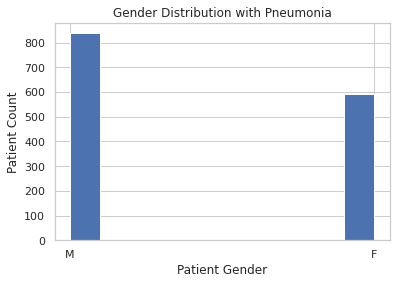

In [15]:
#Explore Gender
plt.xlabel('Patient Gender')
plt.ylabel('Patient Count')
plt.title('Gender Distribution with Pneumonia')

plt.hist(all_xray_df[all_xray_df.Pneumonia==1]['Patient Gender'])

No Significant Difference in Gender distribution with all diseases vs only with Pnemonia. Female patients seems to be slightly less succeptable to Pneumonia looking from this data set but not too significant

In [16]:
# total number of patients
all_xray_df['Patient ID'].unique

<bound method Series.unique of 0             1
1             1
2             1
3             2
4             3
          ...  
112115    30801
112116    30802
112117    30803
112118    30804
112119    30805
Name: Patient ID, Length: 112120, dtype: int64>

(array([67310.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 44810.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

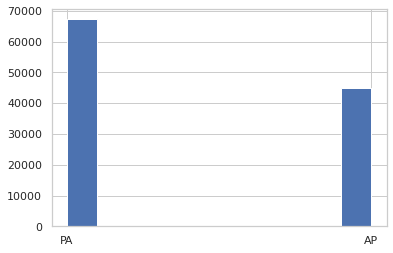

In [17]:
plt.hist(all_xray_df['View Position'])

In [18]:
import os
print(os.listdir("/data"))

['FAQ_CHESTXRAY.pdf', 'ARXIV_V5_CHESTXRAY.pdf', 'images_009', 'images_011', 'images_003', 'images_004', 'README_CHESTXRAY.pdf', 'images_012', 'images_007', 'images_005', 'train_val_list.txt', 'BBox_List_2017.csv', 'images_001', 'images_008', 'LOG_CHESTXRAY.pdf', 'images_006', 'test_list.txt', 'images_002', 'images_010', 'Data_Entry_2017.csv']


In [19]:
from glob import glob
my_glob = glob('/data/images*/images/*.png')
print('Number of Observations: ', len(my_glob)) # check to make sure I've captured every pathwa

Number of Observations:  112120


In [20]:
import pandas as pd
xray_data = pd.read_csv('/data/Data_Entry_2017.csv')
full_img_paths = {os.path.basename(x): x for x in my_glob}
xray_data['full_path'] = xray_data['Image Index'].map(full_img_paths.get)

In [21]:
# get no finding images
noFinding = xray_data[xray_data['Finding Labels'].str.contains('No Finding')]
len(noFinding)

60361

50% of the data has noFinding, which is a good thing. Many should be free of diseases

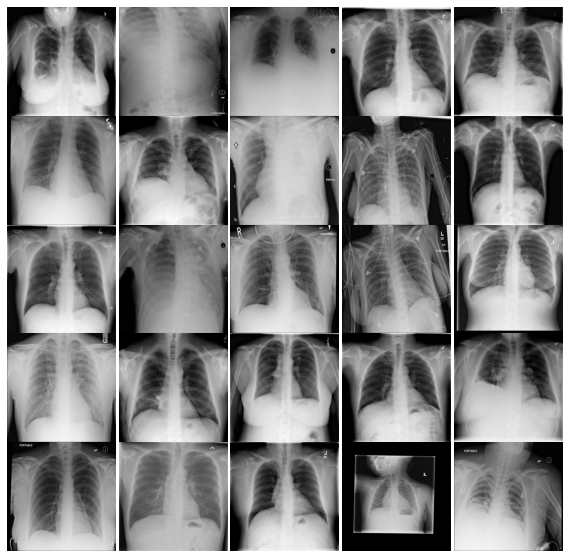

In [22]:

# view a bunch of images
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in my_glob[:25]:
    im = plt.imread(l)
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(im, cmap='gray')
    plt.axis('off')
    i_ += 1
    

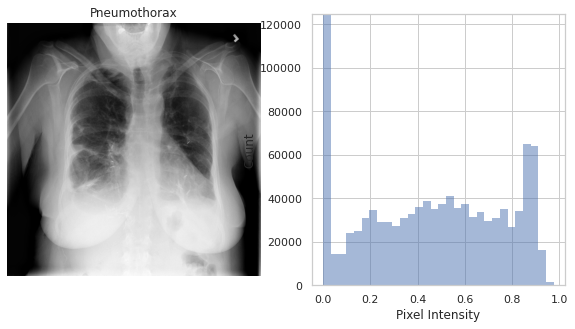

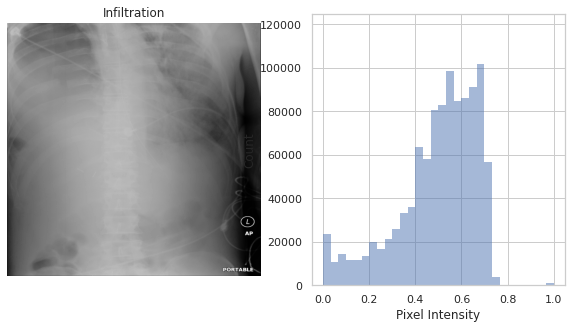

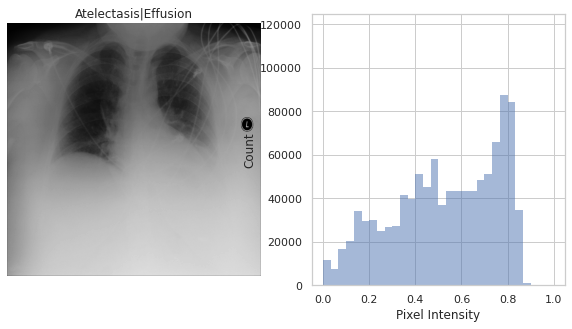

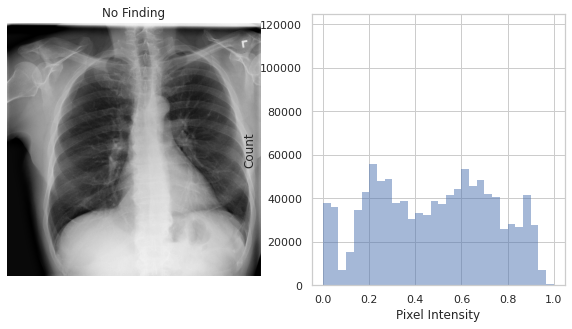

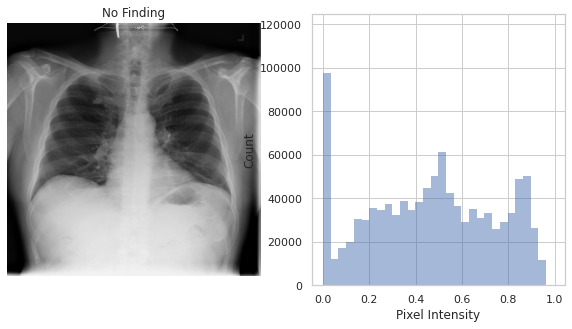

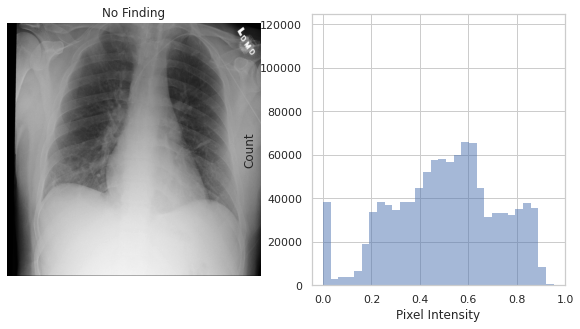

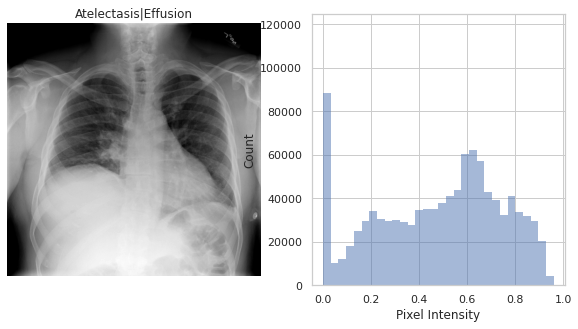

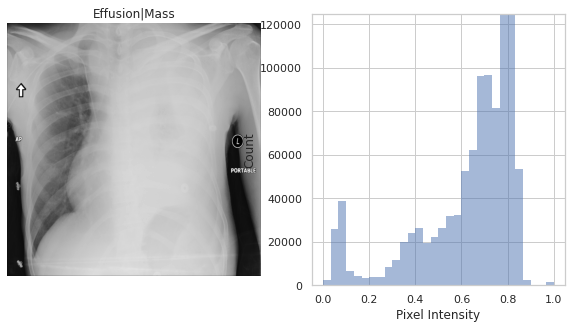

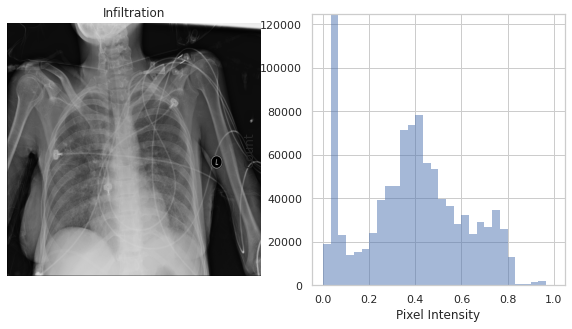

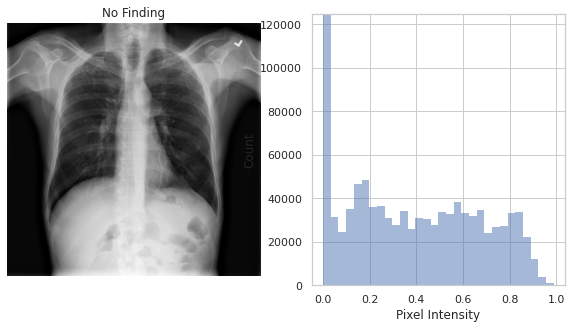

In [23]:
def plotHistogram(a,disease_name):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title(disease_name)
    plt.imshow(a,cmap='gray')
    plt.axis('off')
    #plt.ylim(0,150000)
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    histo.set_ylim([0,125000])
    n_bins = 30
    plt.hist(a.ravel(), bins= n_bins, lw = 0, alpha=0.5);
    #plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    #plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);

for l in my_glob[:10]:
    disease_name = xray_data[xray_data.full_path==l]["Finding Labels"].values[0]
    
    plotHistogram(plt.imread(l),disease_name)
    

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


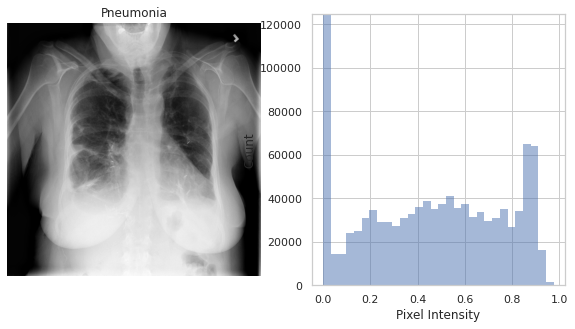

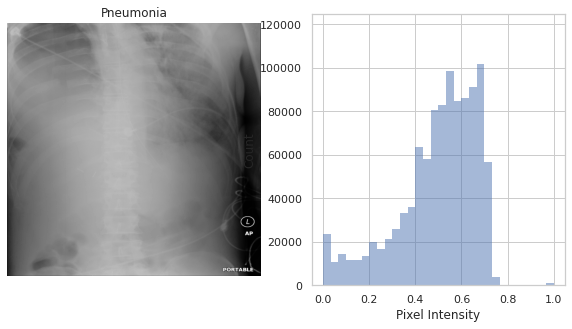

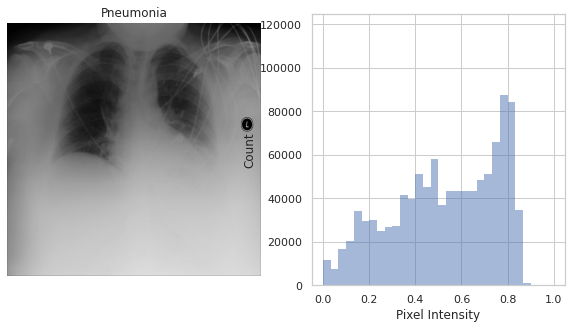

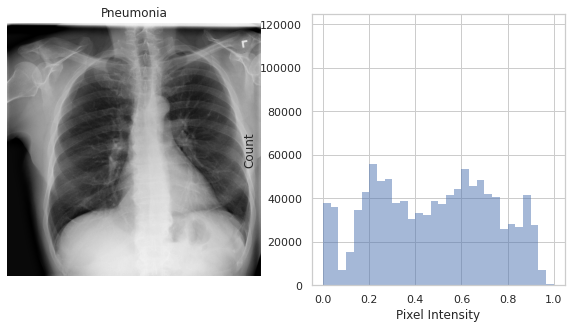

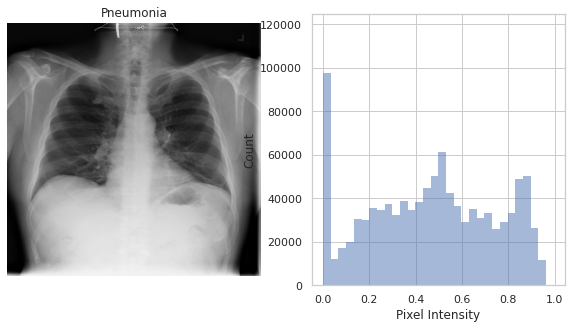

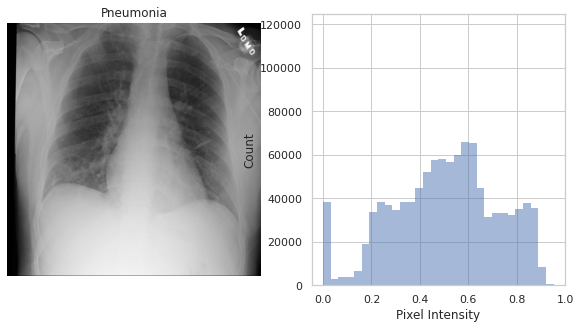

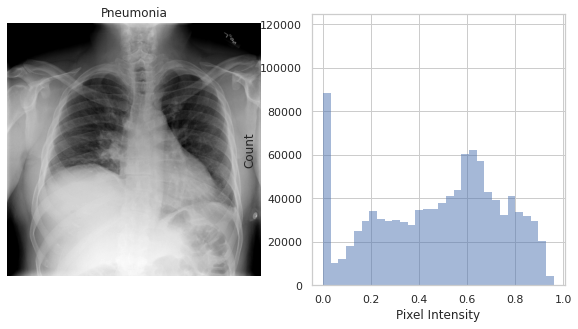

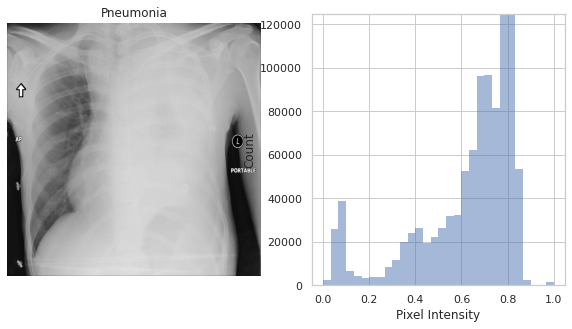

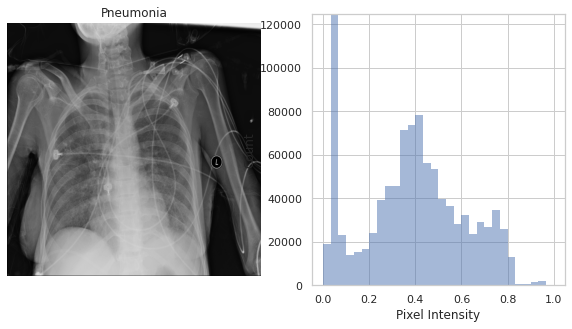

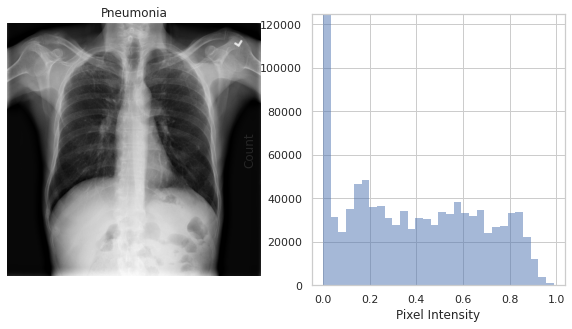

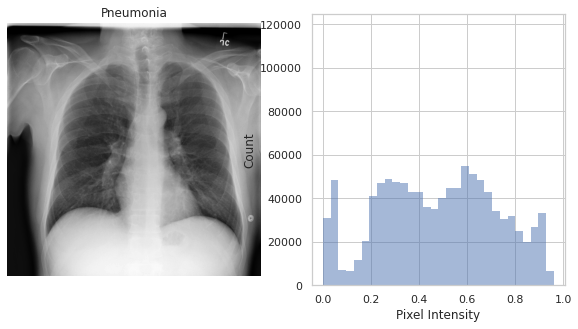

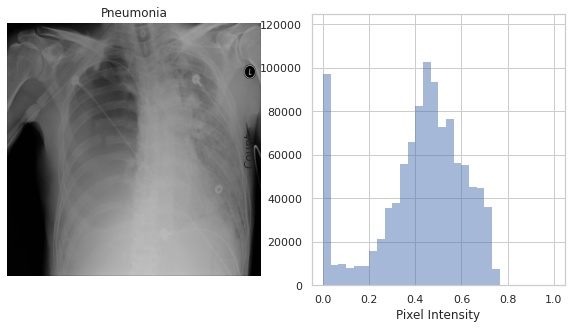

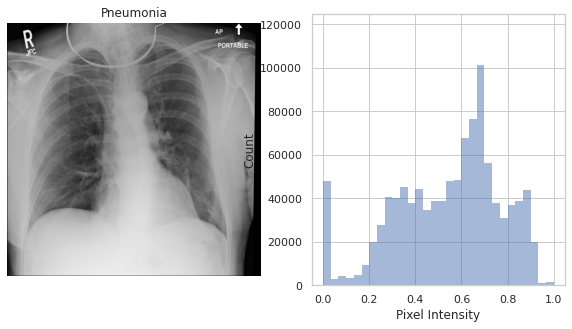

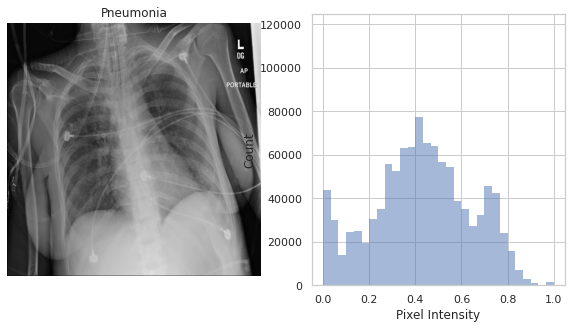

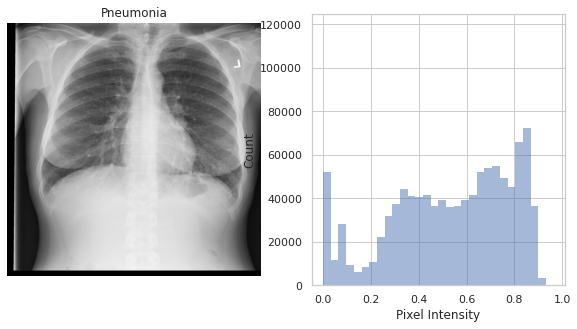

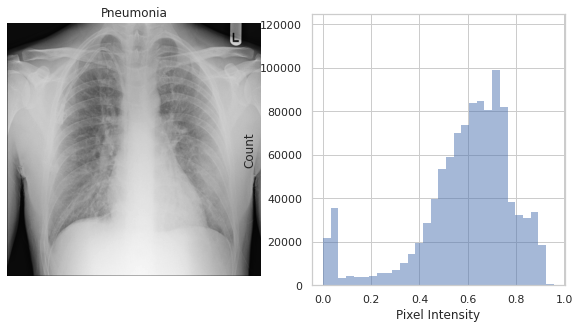

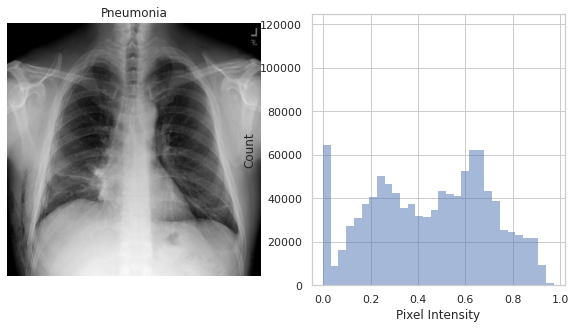

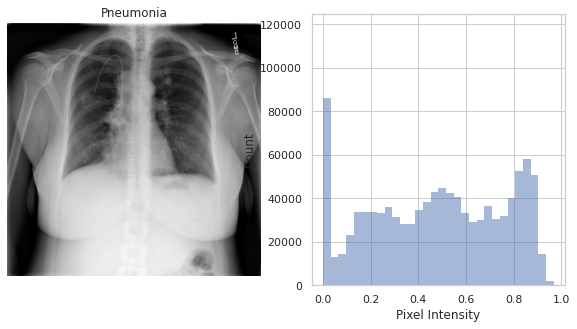

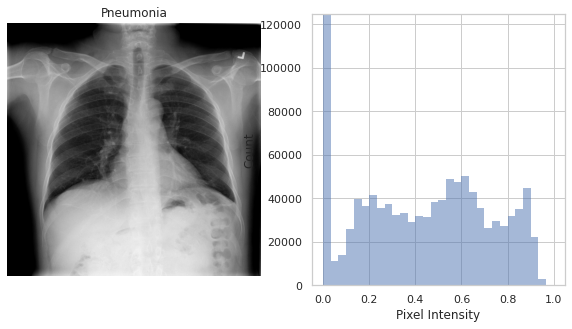

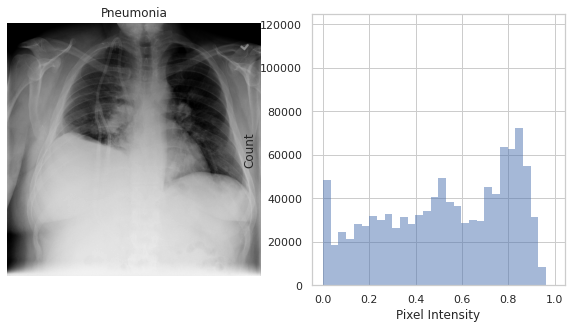

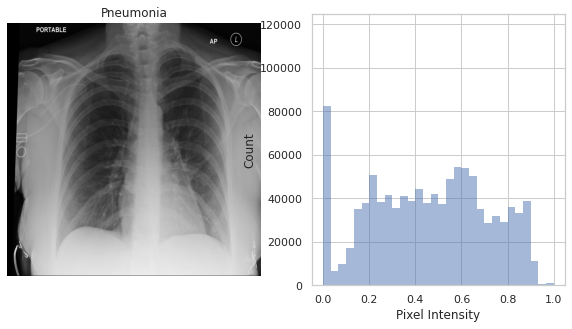

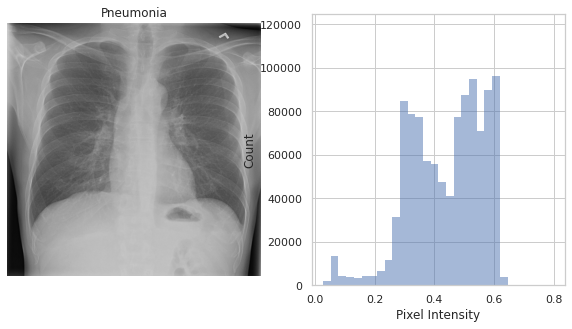

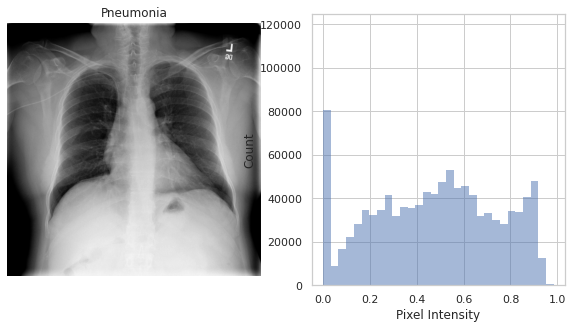

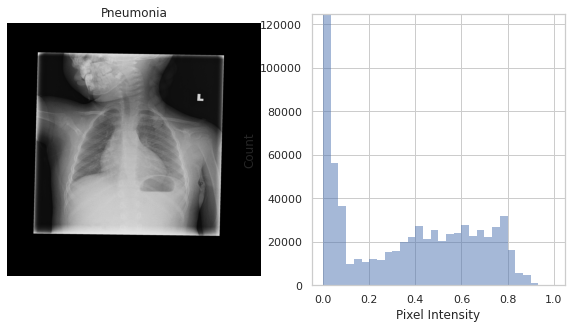

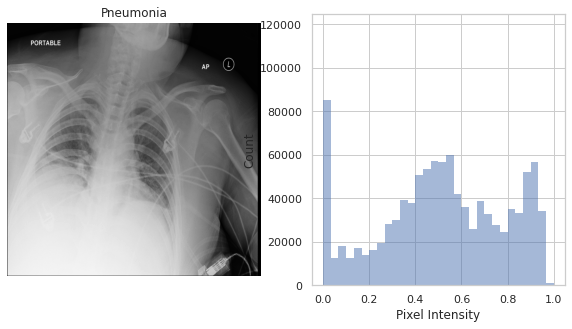

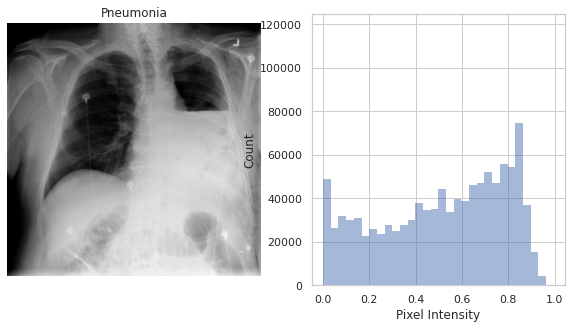

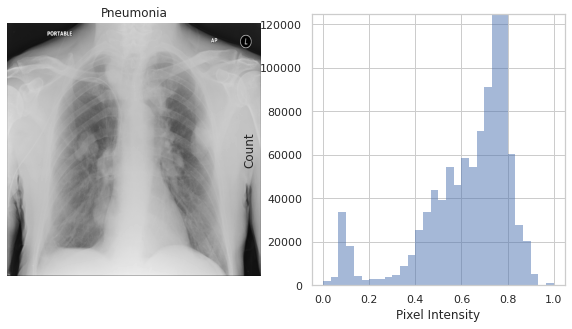

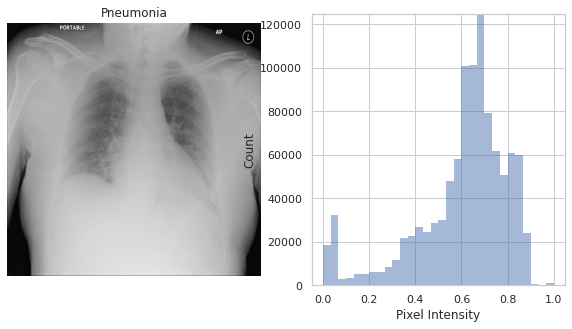

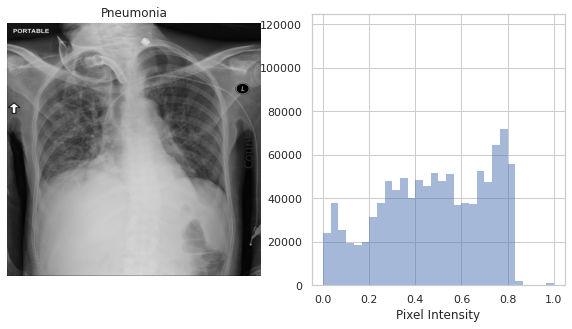

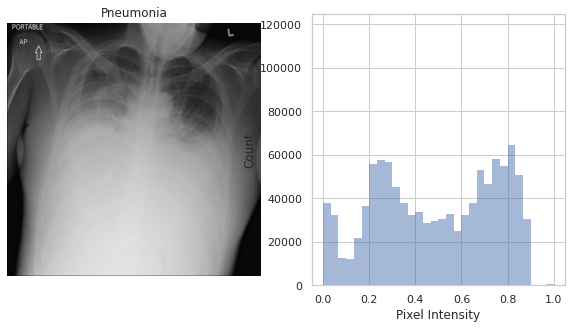

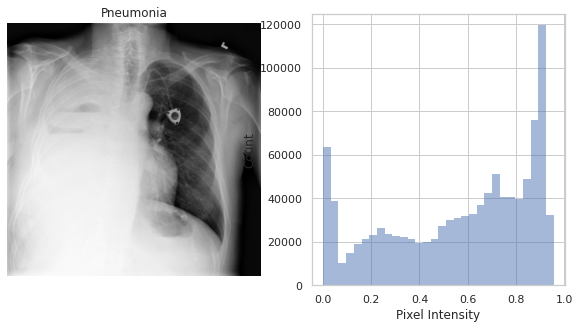

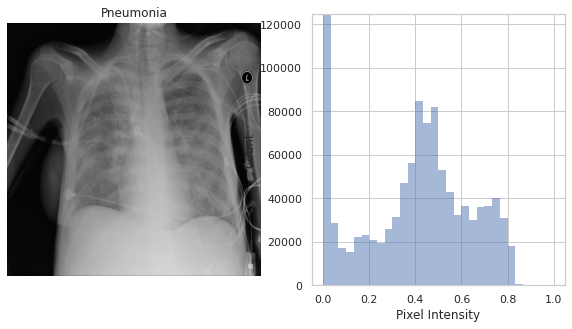

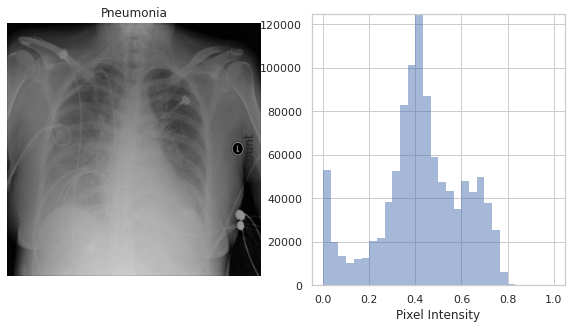

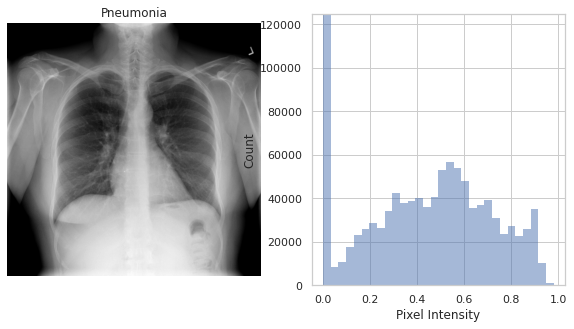

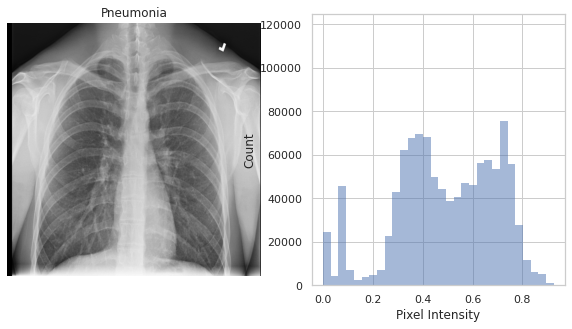

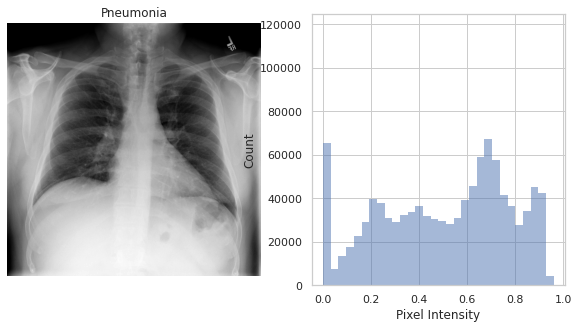

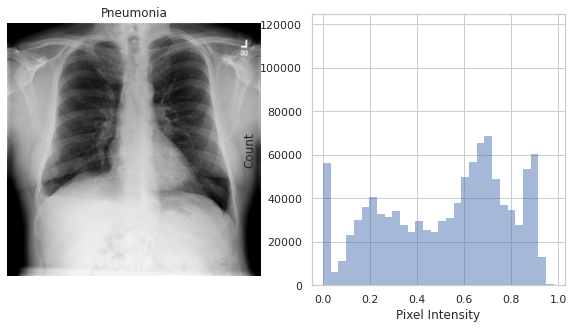

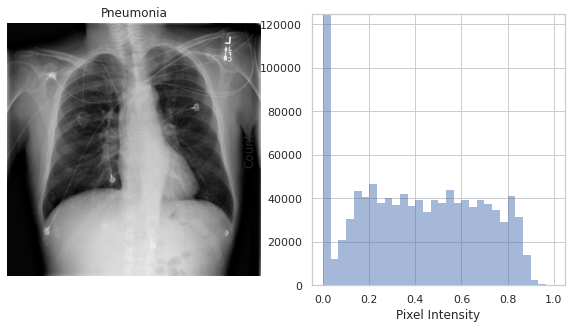

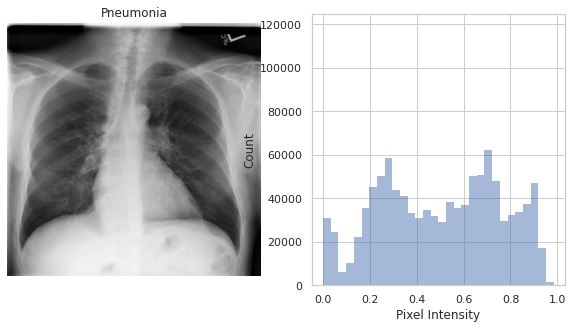

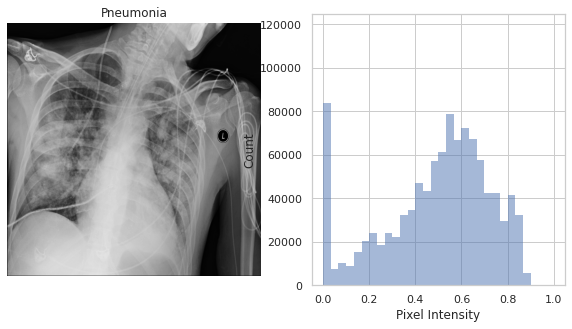

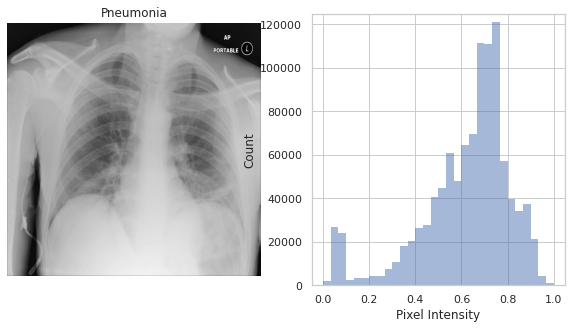

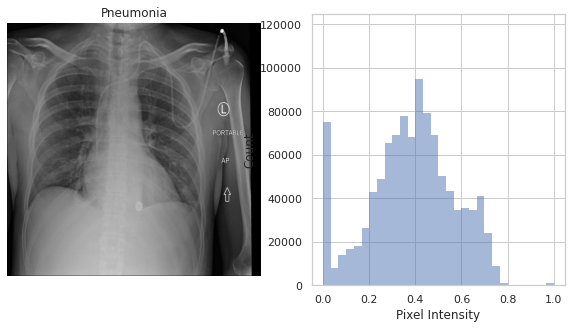

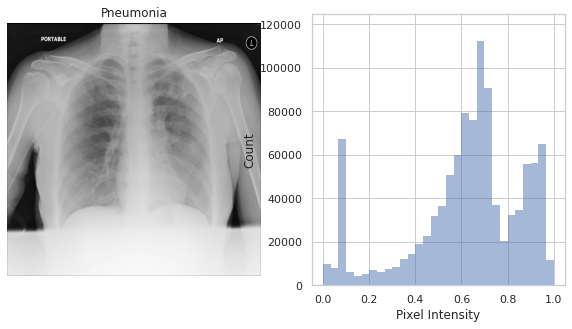

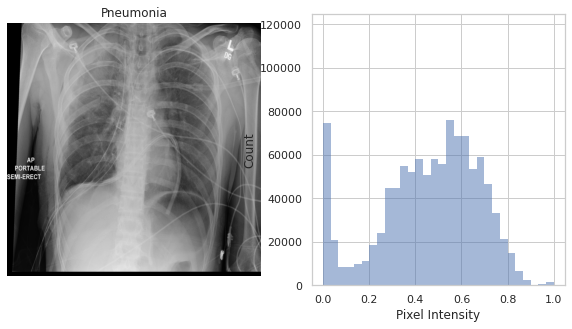

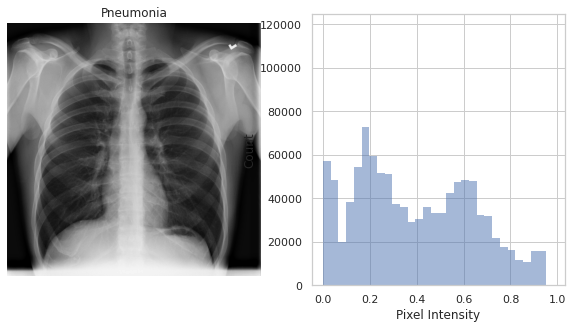

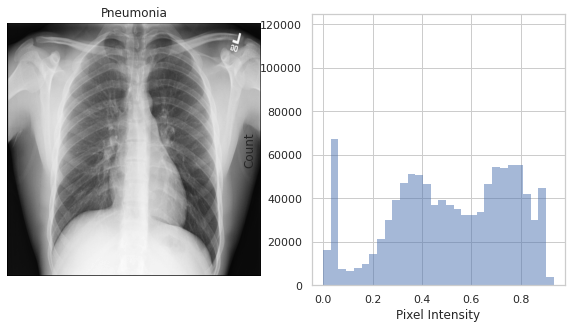

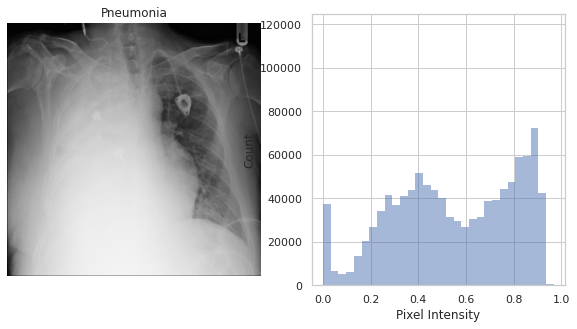

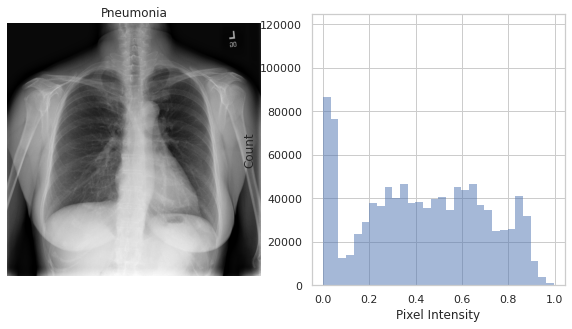

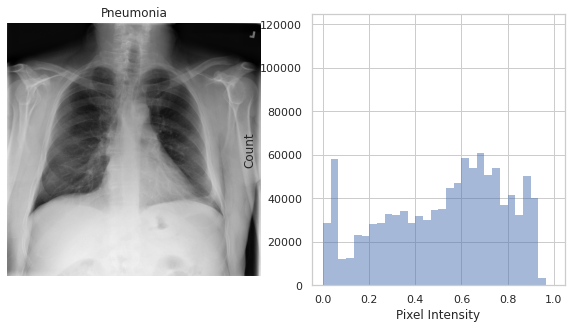

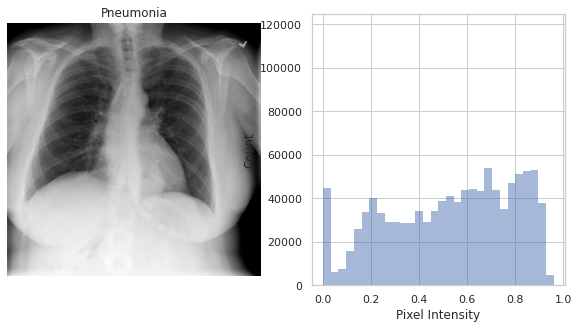

In [24]:
# plot pnemonia one
for l in my_glob[:50]:
    disease_name = xray_data[xray_data.full_path==l]["Finding Labels"].str.contains('Pneumonia').values[0]
    
    plotHistogram(plt.imread(l),'Pneumonia')


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


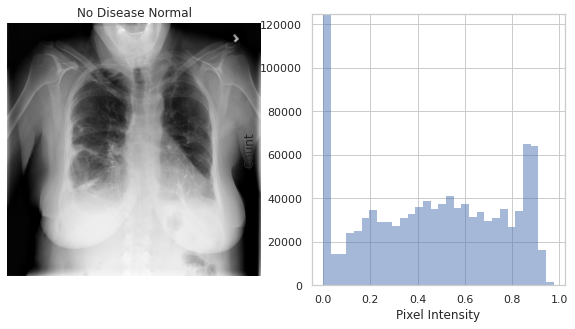

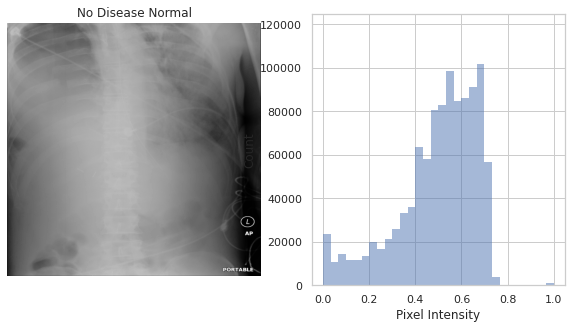

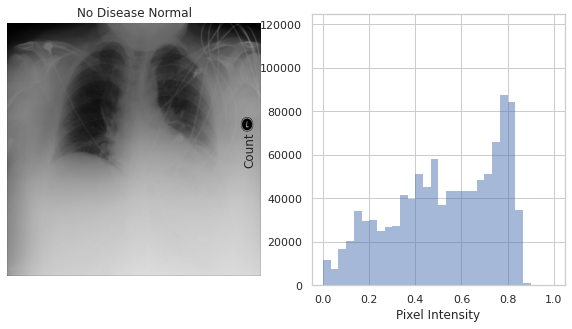

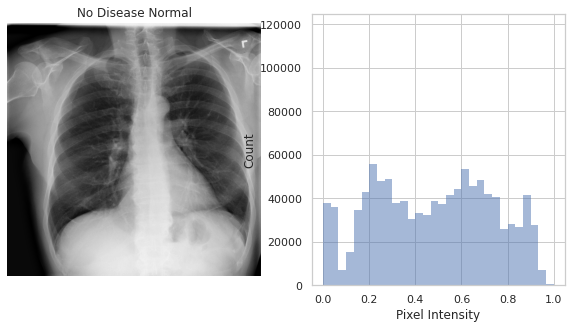

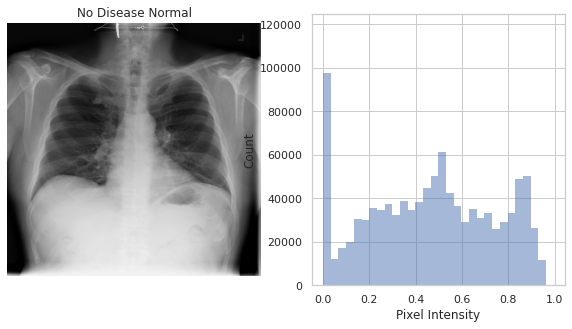

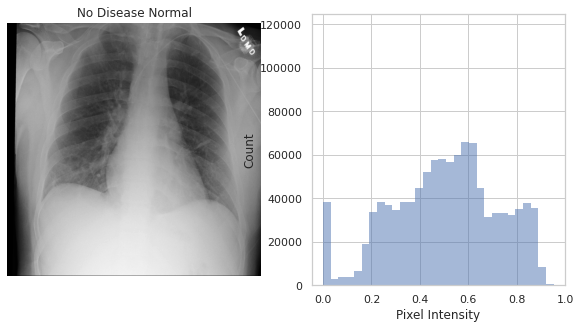

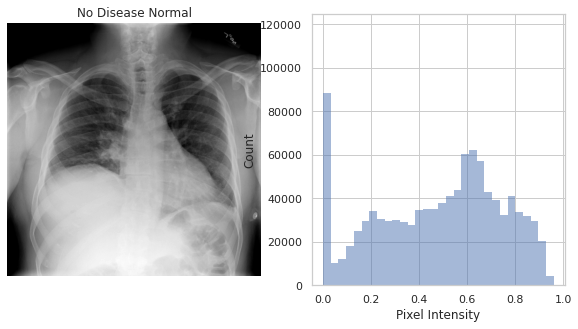

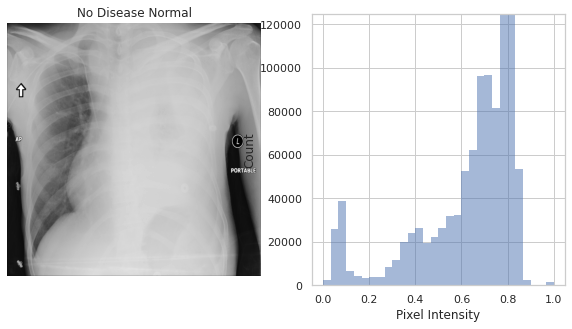

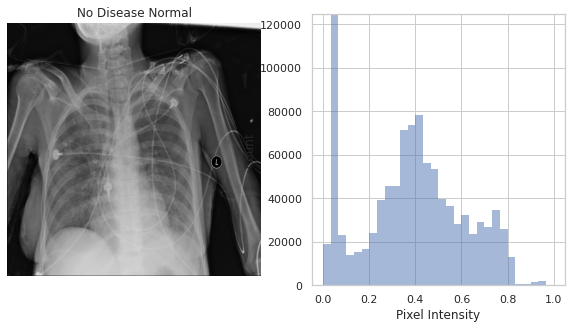

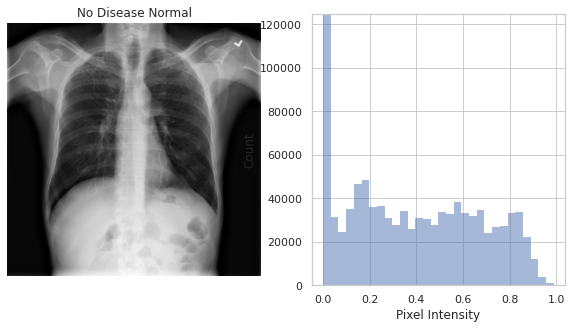

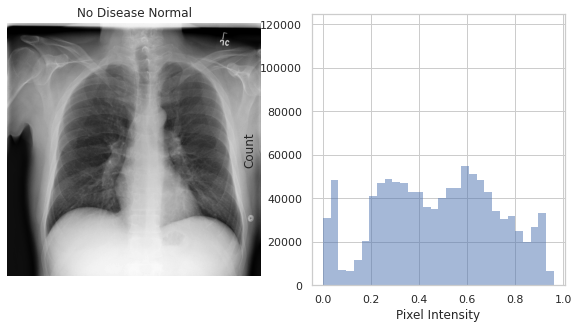

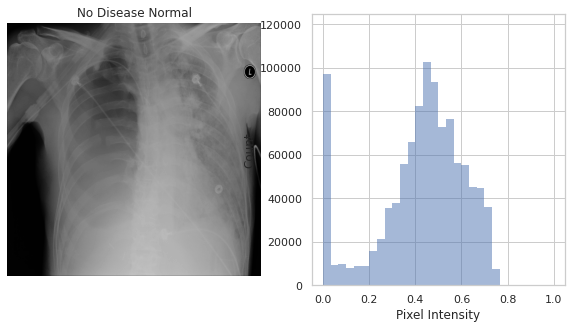

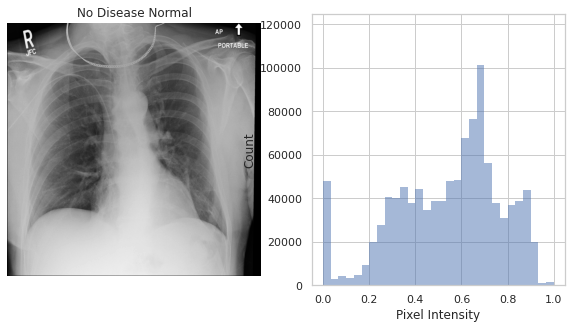

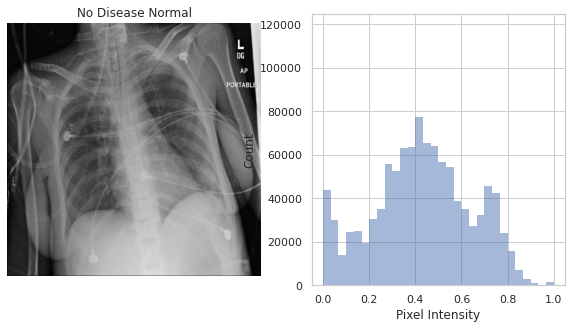

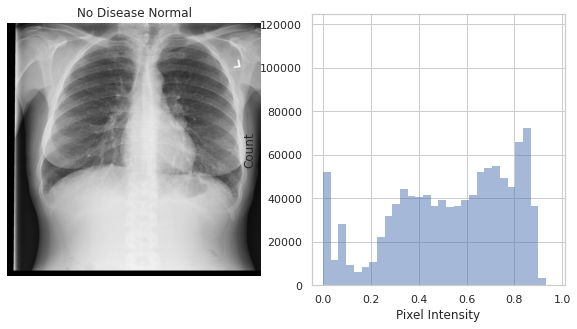

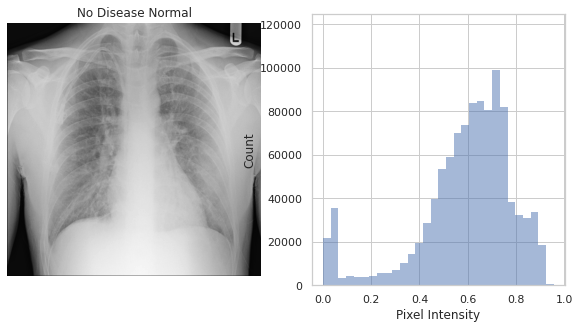

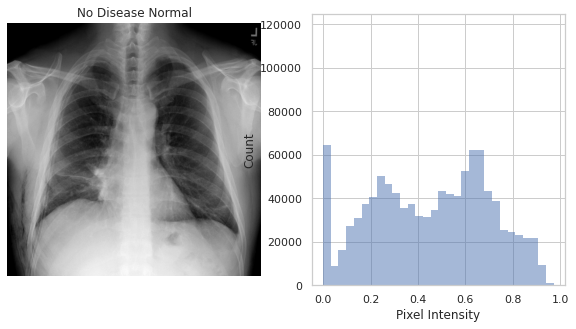

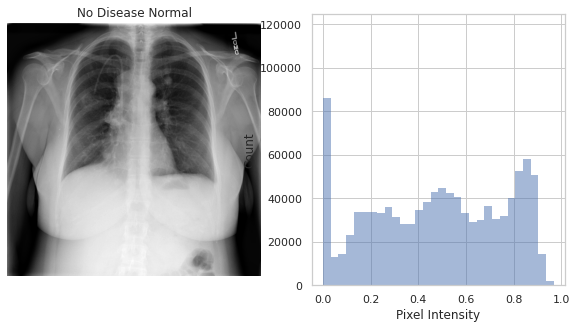

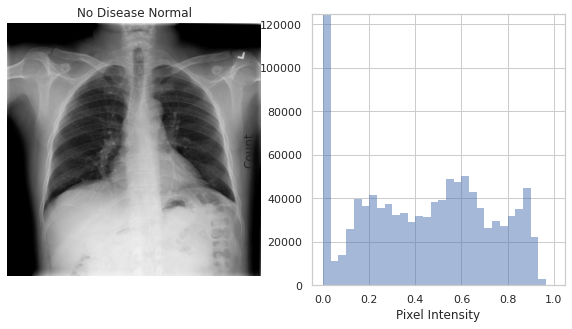

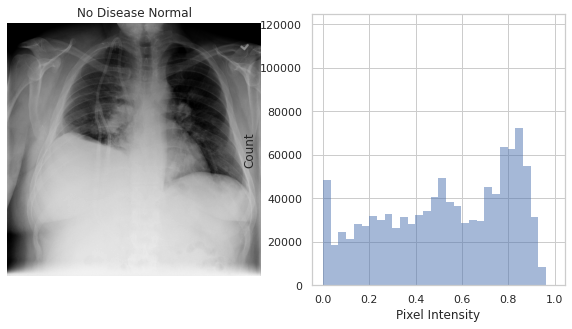

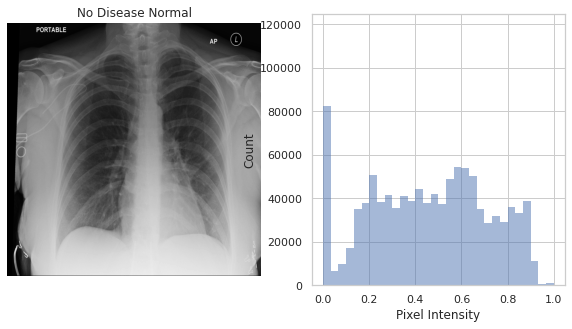

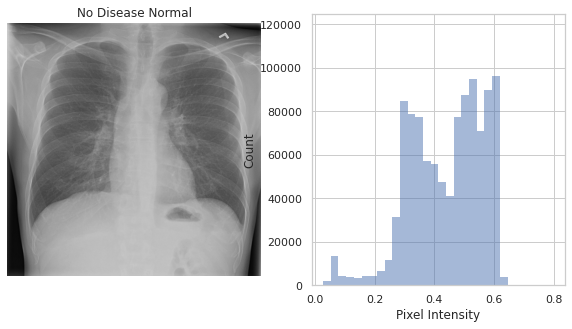

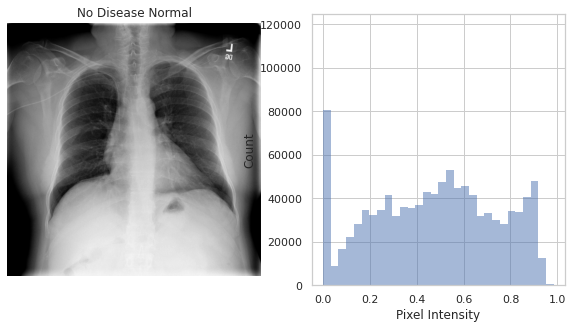

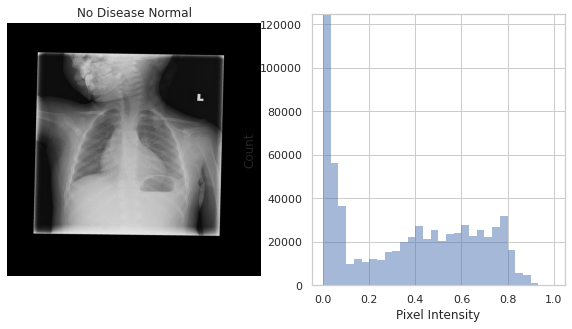

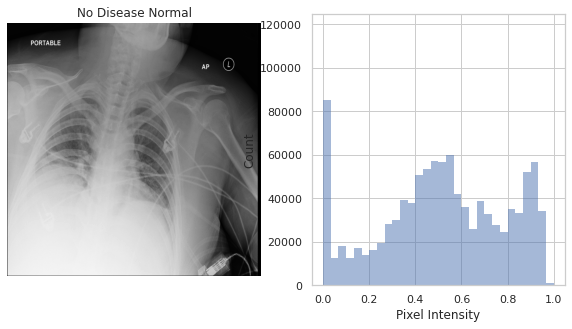

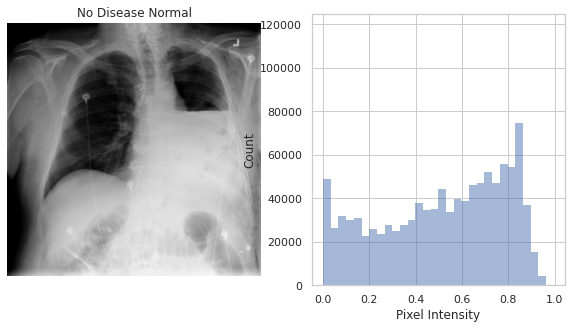

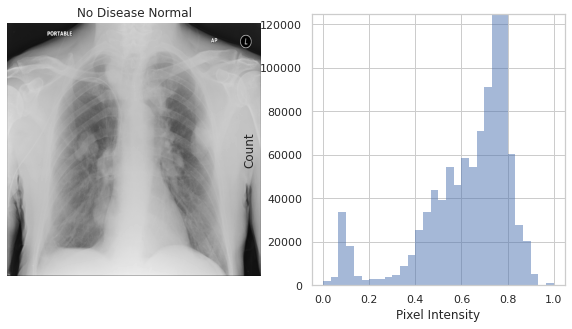

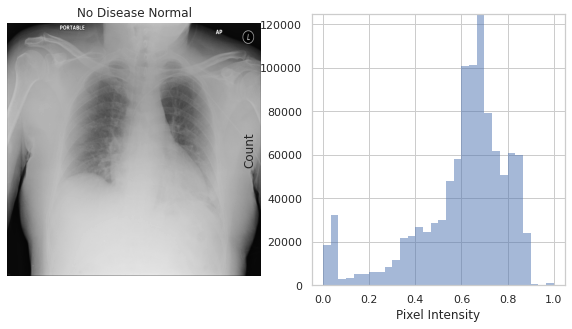

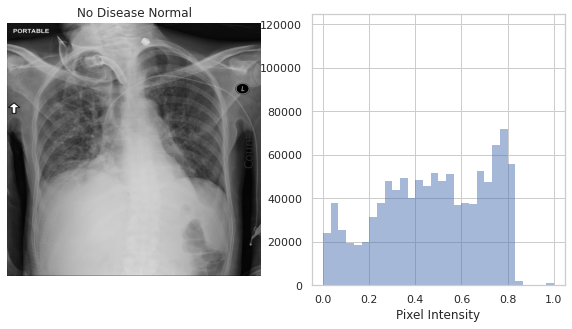

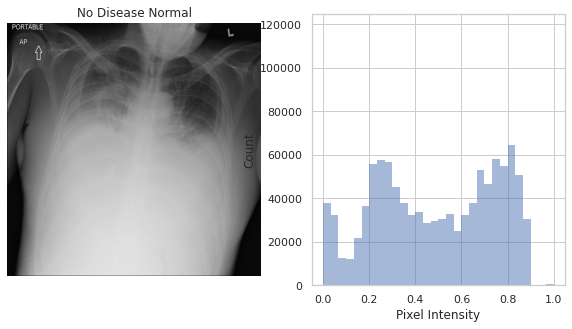

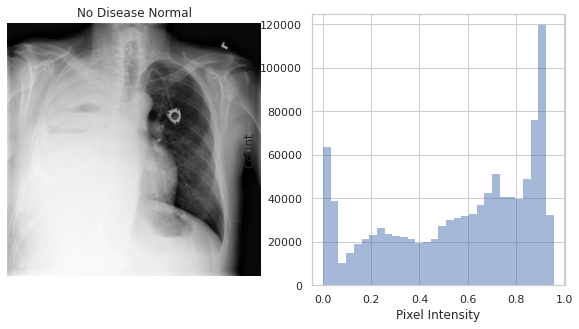

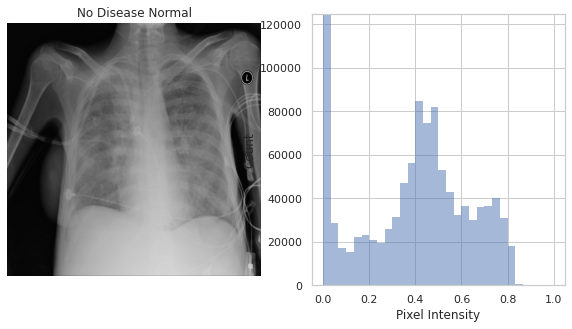

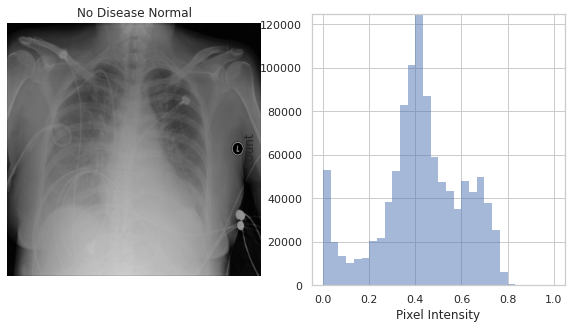

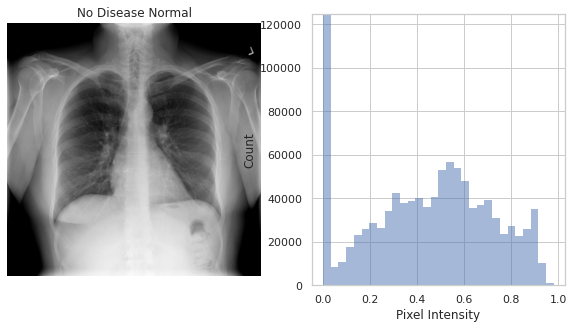

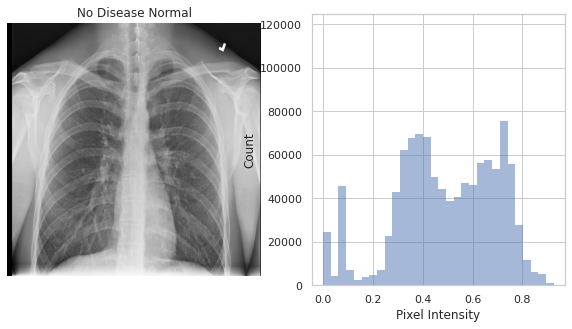

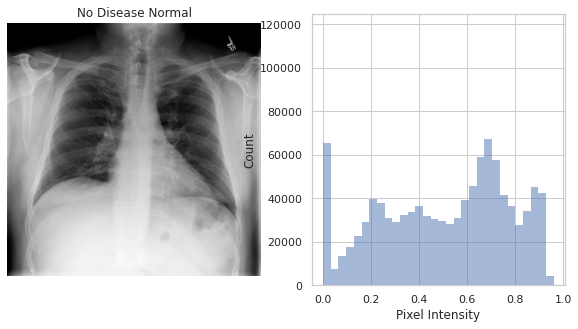

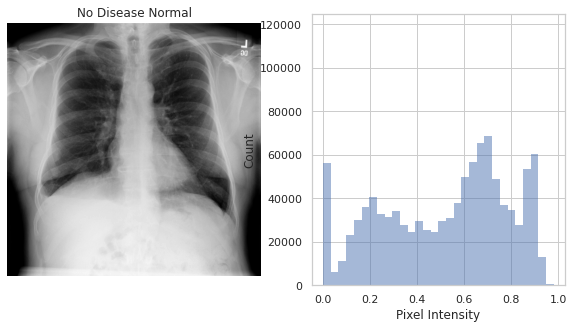

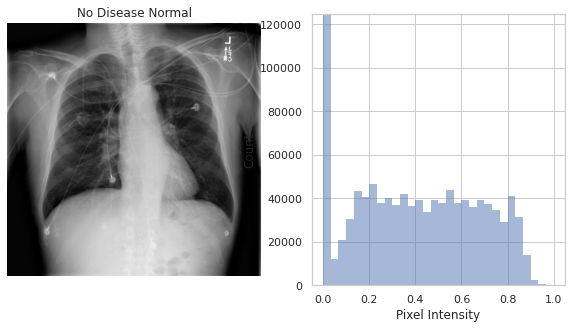

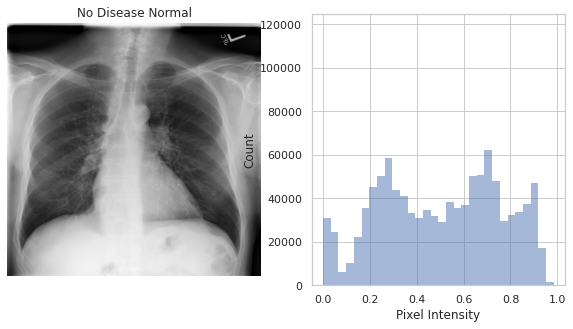

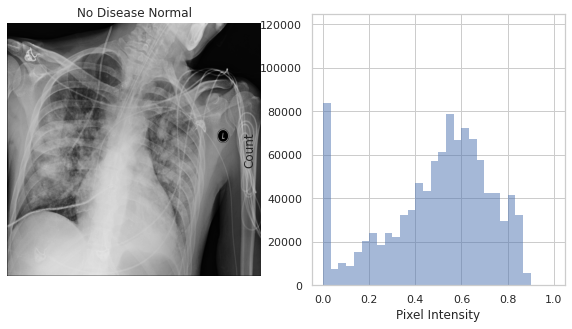

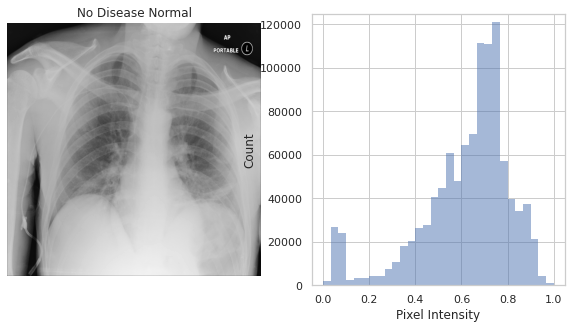

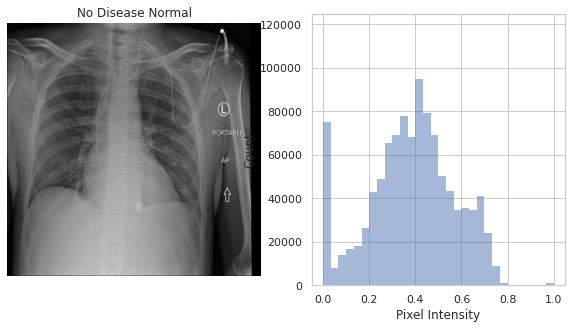

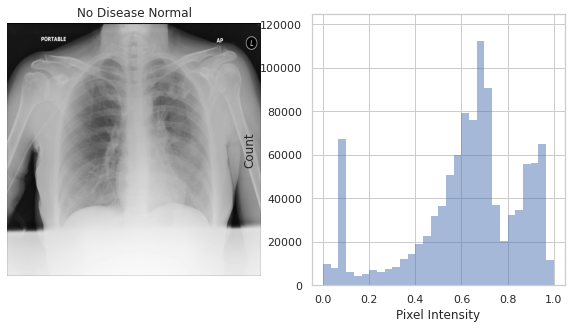

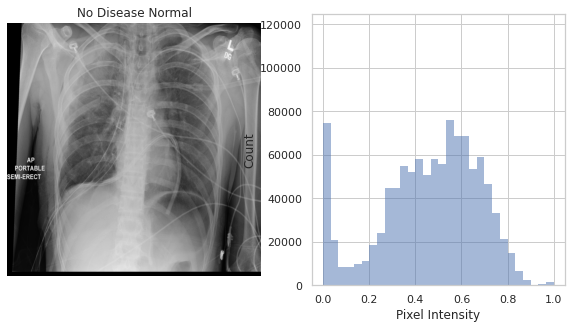

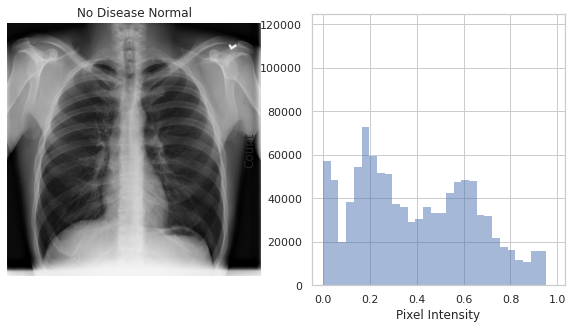

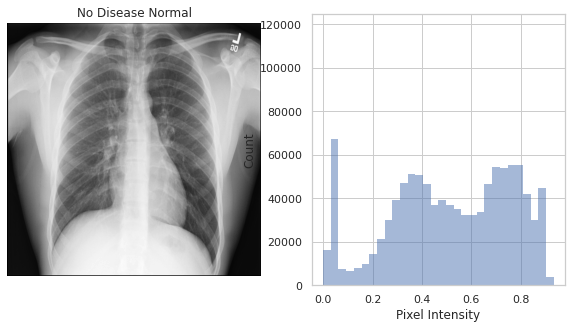

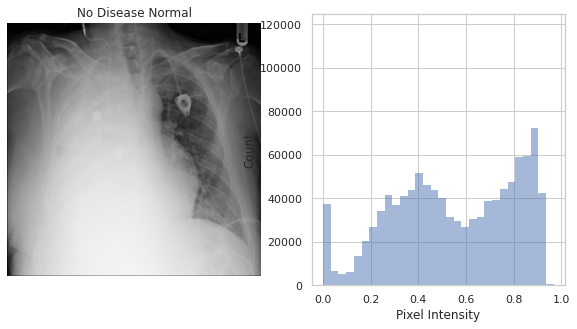

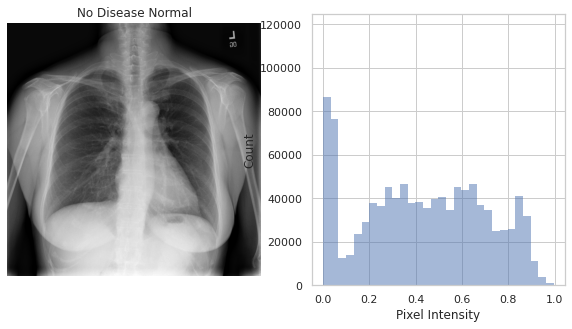

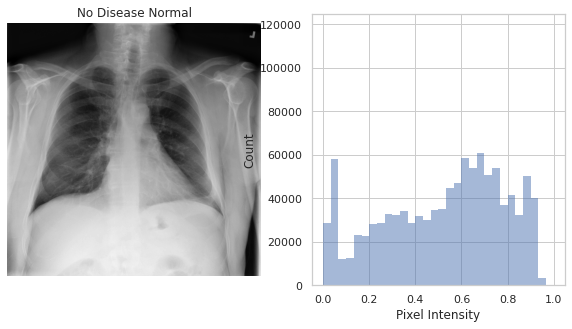

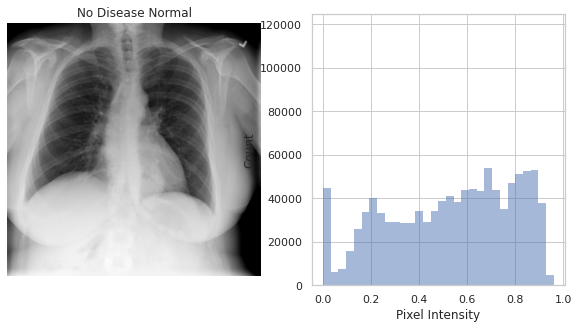

In [25]:
# plot no pnemonia ones
for l in my_glob[:50]:
    disease_name = xray_data[xray_data.full_path==l]["Finding Labels"].str.contains('No Finding').values[0]
    
    plotHistogram(plt.imread(l),'No Disease Normal')


Most of the normal xrays have somewhat of darker images with counts for pixel intensity range (.2-.8) to from ~40000-60000. For xrays with pnemonia, the range is high or low (40000 - 60000) for the same intensity. Again, this is just my interpretation, and I cannot conclusively say anything.
